# Lecture 23 : The Collatz Conjecture

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Part 1 : An Interesting Sequence

### Consider the following operation on an arbitrary integer $n$ such that $n > 1$:
* If the number is even, divide it by two.
* If the number is odd, triple it and add one.  

### We can also write the above operation as a function for $n > 1$
  $$f(n) = \frac{n}{2} \text{ if } n \text{ is even}$$

  $$f(n) = 3n+1 \text{ if } n \text{ is odd}$$

### Next we define the function for an arbitrary positive integer $n \geq 1$
  $$g(n) = 1 \text{ if } n = 1$$

$$g(n) = f(n) \text{ if } n > 1$$
  
### Finally, given $n \geq 1$ we define the infinite sequence
  $$a_0 = n, \qquad a_1 = g(n), \qquad a_2 = g(g(n)), \qquad a_3 =
  g(g(g(n))) \qquad \ldots$$

### For example, for $n = 1$ we have the sequence
  $$a_0 = 1, \qquad a_1 = 1, \qquad a_2 = 1, \qquad a_3 = 1, \qquad
  \ldots$$

### for $n = 2$ we have the sequence
 $$a_0 = 2, \qquad a_1 = 1, \qquad a_2 = 1, \qquad a_3 = 1, \qquad \ldots$$
    
### for $n = 3$ we have the sequence
$$a_0 = 3, \quad a_1 = 10, \quad a_2 = 5, \quad a_3 = 16,\quad a_4 = 8, \quad a_5 = 4, \quad a_6 = 2, \quad a_7 = 1,\quad a_8 = 1, \quad \ldots$$

### We can use Python to explore this sequence for different starting values.

In [ ]:
def sequence (n):
    seq = [n]
    while (n != 1):
        if (n % 2 == 0):
            n //= 2
        else:
            n = 3*n+1
        seq.append(n)
    return seq

In [ ]:
seq = sequence(9)
print (seq)
print ('number of steps required to reach 1 is',len(seq)-1)

In [ ]:
start = 97
#start = 670617279
#start = 9780657630
#start = 75128138247
seq = sequence(start)

In [ ]:
plt.plot(seq)
plt.title("Sequence for starting value %i has %i steps" % (start,len(seq)-1));

## The **Collatz Conjecture** is that this sequence will eventually reach the number $1$, regardless of which postive integer is chosen intitially.


### *Definition:* Given a positive integer $n \geq 1$, the *smallest* $k$ such that $a_k = 1$ is called the **total stopping time**.  

### If such a $k$ does not exist, we say that the total stopping time is infinite.

## The **Collatz conjecture** asserts that the total stopping time of every $n \geq 1$ is finite.

### Here is a list of the total stopping times for $n$ in $1, \ldots, 20$.

$$0, 1, 7, 2, 5, 8, 16, 3, 19, 6, 14, 9, 9, 17, 17, 4, 12, 20, 20, 7$$

### We can use Python to graph the total stopping times for $n$ in $1, \ldots, 100000$.

In [ ]:
len_seq = []
for i in range(100000):
    seq = sequence(i+1)
    len_seq.append(len(seq)-1)
plt.scatter(range(1,100001),len_seq,s=1,color='maroon');

### As of 2020, the conjecture has been checked by computer for all values up to $2^{68} \approx 2.95 \times 10^{20}$.

### This computer evidence is not sufficient to prove the conjecture is true for all starting values since counterexamples still may be found when considering very large numbers!

### The following table of largest total stopping times was taken from the Wikipedia site for the Collatz conjecture.

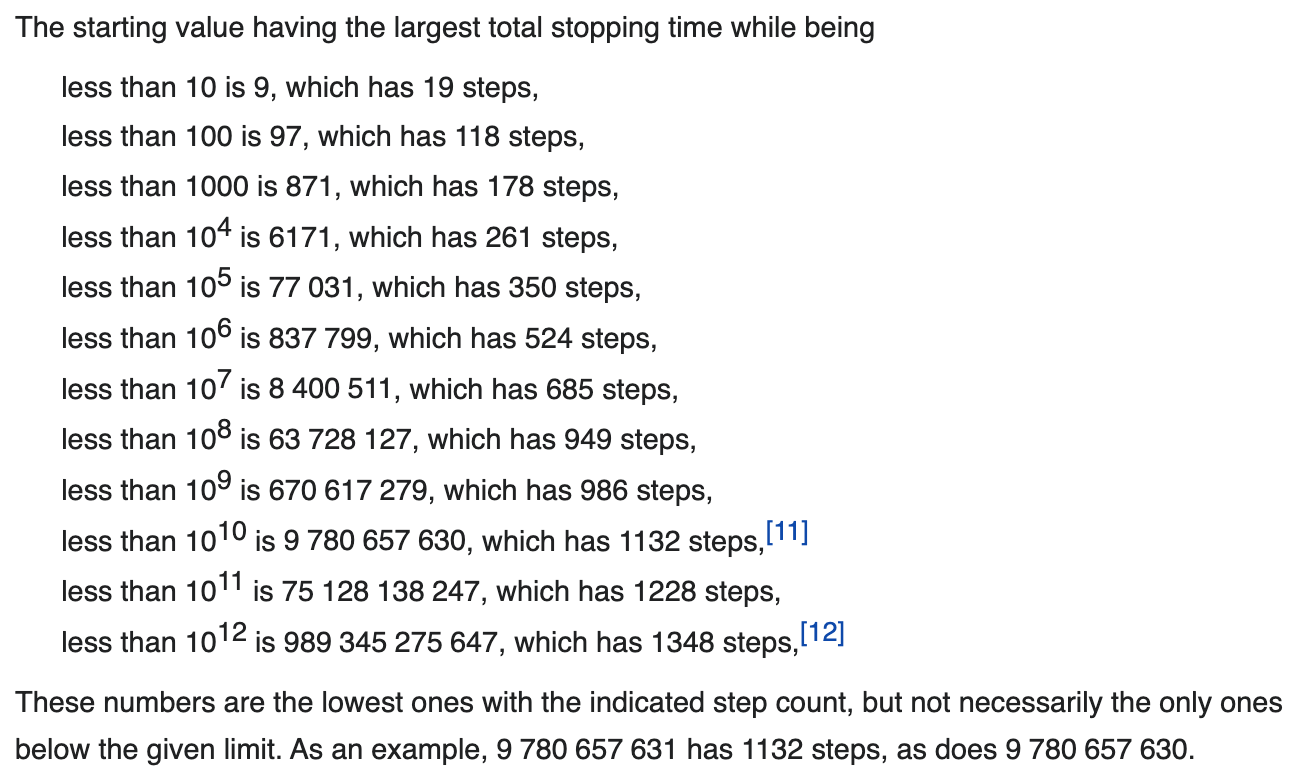

## We can calculate the largest total stopping time below $N$ using Python

# Part 2 : Calculating Largest Total Stopping Times (Sequential)

In [ ]:
%%timeit -n1 -r1
N = 100000
len_seq = []
for i in range(N):
    seq = sequence(i+1)
    len_seq.append(len(seq)-1)
max_start = np.argmax(len_seq)+1
max_total = np.max(len_seq)
print ("start <= %i with largest total is %i which has %i steps"%(N,max_start,max_total))

## With Python we can easily handle $N$ values up to around one hundred thousand.

## We can handle larger values of $N$ using a C program instead.

In [ ]:
%%writefile collatz.c
#include <stdio.h>
#include <stdlib.h>

typedef unsigned int uint32;
typedef unsigned long long int uint64;

/* compute the total stopping time of a given start value */
uint32 total_stopping_time (uint64 start) {
    uint32 total = 0;
    uint64 a_i = start;
    while (a_i != 1) {
        total += 1;
        if (a_i % 2 == 0) {
            a_i /= 2;
        } else {
            a_i = 3*a_i + 1;
        }
    }
    return total;
}

int main (int argc, char** argv) {

    /* get N from the command line */
    if (argc < 2) {
        printf ("Command usage : %s %s\n",argv[0],"N");
        return 1;
    }
    uint64 N = atol(argv[1]);

    /* compute the start less than or equal to N with largest total stop */
    uint64 max_start = 1;
    uint32 max_total = 0;
    for (uint64 start=1; start <= N; start++) {
        uint64 total = total_stopping_time (start);
        if (total > max_total) {
            max_total = total;
            max_start = start;
        }
    }

    /* print results */
    printf ("The starting value less than or equal to %llu\n",N);
    printf ("  having the largest total stopping time is %llu\n",max_start);
    printf ("  which has %u steps\n",max_total);

}

### Compile with optimizations turned on.

In [ ]:
!gcc -O3 -o collatz collatz.c

### Using C we can easily handle $N$ values up to around 10 million.

In [ ]:
!time ./collatz 10000000

# Part 3 : Calculating Largest Total Stopping Times (GPU)

### Let's start the development of a CUDA kernel for finding the largest total stopping time.

### Version 1 of the collatz kernel is written in the style of our final sum kernel (version 6).    

### Note the use of atomicExch (atomic exchange) to keep track of the starting value with the largest total stopping time.

### Using version 1 of the collatz kernel with 256 threads we can easily handle $N$ values up to around 100 million.

### Discussion: What is the major limitation of version 1 kernel?

In [ ]:
%%writefile gpu_collatz_v1.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned int uint32;
typedef unsigned long long int uint64;

/* compute the total stopping time of a given start value */
__device__ uint32 total_stopping_time (uint64 start) {
    uint32 total = 0;
    uint64 a_i = start;
    while (a_i != 1) {
        total += 1;
        if (a_i % 2 == 0) {
            a_i /= 2;
        } else {
            a_i = 3*a_i + 1;
        }
    }
    return total;
}

__global__ void collatzKernel(uint64 N) {

    __shared__ uint64 max_start;
    __shared__ uint32 max_total;

    int thread_num = threadIdx.x;
    int num_threads = blockDim.x;

    if (thread_num == 0) {
        max_start = 1;
        max_total = 0;
    }
    __syncthreads();

    uint64 thread_max_start = 1;
    uint32 thread_max_total = 0;
    for (uint64 n = 1+thread_num;n<=N;n+=num_threads) {
        uint32 total = total_stopping_time(n);
        if (total > thread_max_total) {
            thread_max_start = n;
            thread_max_total = total;
        }
    }
    atomicMax(&max_total,thread_max_total);
    __syncthreads();

    if (max_total == thread_max_total) {
        atomicExch(&max_start,thread_max_start);
    }
    __syncthreads();

    if (thread_num == 0) {
        /* output the results */
        printf ("The starting value less than or equal to %llu\n",N);
        printf ("  having the largest total stopping time is %llu\n",max_start);
        printf ("  which has %u steps\n",max_total);
    }
}

int main (int argc, char** argv) {

    /* get N and num_threads from the command line */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }

    uint64 N = atol(argv[1]);
    int num_threads = atoi(argv[2]);

    printf ("num_threads = %d\n",num_threads);
    collatzKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();
}

In [ ]:
!nvcc -arch=sm_75 -o gpu_collatz_v1 gpu_collatz_v1.cu

In [ ]:
!time ./gpu_collatz_v1 100000000 256

### How do we unleash the full power of the GPU?  

### We will need to use more than one thread block in order to make use of every SM on the GPU.  

### This will require us to use substantially more threads.  

### Discussion: What is the smallest amount of work we can assign to each thread?  

### For example, if we have 10000 dishes to wash what is the smallest amount of work we could have each dishwasher do?  How many dishwashers would we need in this case?

### If we want to check all starting values at or below 10 million for the largest total stopping time what is the smallest amount of work we could have each thread do?  How many threads would we need in this case?

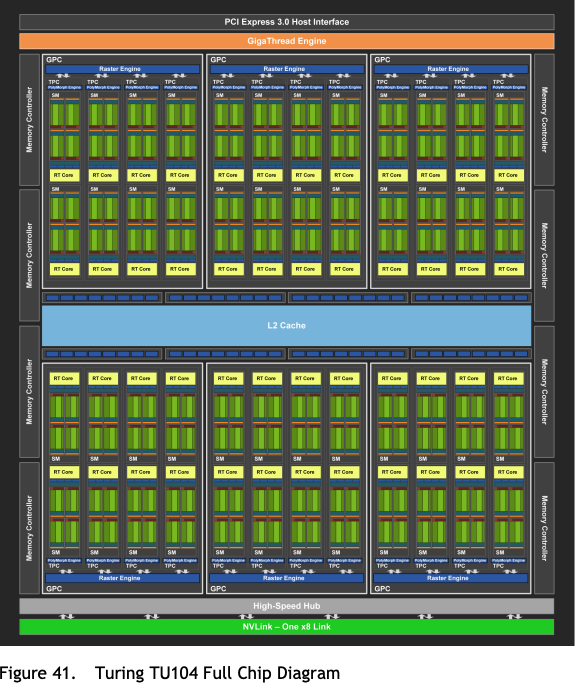

### For kernel version 2, we assign each thread the task of computing a total stopping time for a single number.  

### For this kernel version we bump $N$ up to 1 billion.

### That means that we will need 1 billion threads!  

### We group the threads into thread blocks.  While threads in the same thread block all have to run on the same SM, different thread blocks can run on different SMs in parallel.  

### Once we specify the number of threads per block (we call this parameter B), then the minimum number of thread blocks required is $G=(N+B-1)/B$.  

### For example, if $N = 100$ and $B = 32$ then $G=(N+B-1)/B = (100+32-1)/32 = 4$ which makes sense in this case since we will thread 4 thread blocks.

### Note that when N is not a multiple of B, there will be some extra threads that will end up idling.

### Note that line 26 ensures that the extra threads idle.

### To compute the thread number we use the CUDA code

*blockIdx.x * blockDim.x + threadIdx.x*

### This formula multiples the *block index* times the *number of threads per block* and adds in the *thread index*.  

### For example, consider the case where you have 32 thread blocks of 32 threads each.  

### If the block index is 25 and the thread index is 15, what is the thread number?

### Answer : 25*32+15 = 815

### If the thread number is $765$, what is the block index and thread index?

### Answer part 1: To find the block index we use the integer division formula $765 / 32 = 23$.  

### Answer part 2: To find the thread index we use the mod formula $765 \text{ mod } 32 = 765 - 23*32 = 29$.  

### To ensure the kernel works we have the thread that found the largest total stopping time under 1 billion print.

### From the Wiki page above we see that the largest total stopping time for staring values at or under 1 billion is 986.

In [ ]:
%%writefile gpu_collatz_v2.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned int uint32;
typedef unsigned long long int uint64;

/* compute the total stopping time for a given number n */
__device__ uint32 total_stopping_time (uint64 a_i) {
    uint32 total = 0;
    while (a_i != 1) {
        if (a_i % 2 == 0) {
            a_i = a_i/2;
        } else {
            a_i = (3*a_i+1);
        }
        total += 1;
    }
    return total;
}

__global__ void collatzKernel(uint64 N) {

    uint64 thread_num = (uint64)blockIdx.x*blockDim.x + threadIdx.x;
    if (thread_num < N) {
        uint32 total = total_stopping_time(thread_num+1);
        if (total == 986) {
            printf ("starting value n = %llu has total stopping time 986\n",thread_num+1);
        }
    }
}

int main (int argc, char** argv) {

    /* B is the number of threads per block */
    /* we typically choose B to be a multiple of 32 */
    /* the maximum value of B is 1024 */
    /* get N and B from the command line */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","B");
        return 1;
    }
    uint64 N = atol(argv[1]);
    int B = atoi(argv[2]);

    /* G is the number of thread blocks */
    /* the maximum number of thread blocks G is 2^31 - 1 = 2147483647 */
    /* We choose G to be the minimum number of thread blocks to have at least N threads */
    int G = (N+B-1)/B;
    printf ("N = %llu\n",N);
    printf ("threads per block B = %d\n",B);
    printf ("number of thread blocks G = %d\n",G);
    printf ("number of threads G*B = %llu\n",(uint64)G*B);
    collatzKernel <<< G, B >>> (N);
    cudaDeviceSynchronize();
}

In [ ]:
!nvcc -arch=sm_75 -o gpu_collatz_v2 gpu_collatz_v2.cu

In [ ]:
!time ./gpu_collatz_v2 1000000000 256

### Version 2 of the kernel is not complete since we are using the fact that we already know the answer.

### In the next lecture we will learn some new CUDA programming techniques and complete the Collatz kernel.